In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cwru-bearing-datasets/CWRU_48k_load_1_CNN_data.npz
/kaggle/input/cwru-bearing-datasets/feature_time_48k_2048_load_1.csv
/kaggle/input/cwru-bearing-datasets/raw/IR021_1_214.mat
/kaggle/input/cwru-bearing-datasets/raw/B014_1_190.mat
/kaggle/input/cwru-bearing-datasets/raw/OR007_6_1_136.mat
/kaggle/input/cwru-bearing-datasets/raw/OR014_6_1_202.mat
/kaggle/input/cwru-bearing-datasets/raw/B007_1_123.mat
/kaggle/input/cwru-bearing-datasets/raw/IR007_1_110.mat
/kaggle/input/cwru-bearing-datasets/raw/B021_1_227.mat
/kaggle/input/cwru-bearing-datasets/raw/Time_Normal_1_098.mat
/kaggle/input/cwru-bearing-datasets/raw/OR021_6_1_239.mat
/kaggle/input/cwru-bearing-datasets/raw/IR014_1_175.mat


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
data_time = pd.read_csv("/kaggle/input/cwru-bearing-datasets/feature_time_48k_2048_load_1.csv")

In [4]:
# Scale each column to have zero mean and standard deviation equal to 1
scaler = StandardScaler()
train_data, test_data = train_test_split(data_time, test_size=750, stratify=data_time['fault'], random_state=1234)

# Scale the training data
train_data_scaled = scaler.fit_transform(train_data.iloc[:, :-1])
train_data_scaled = torch.tensor(train_data_scaled, dtype=torch.float32)

In [5]:
#train_labels = torch.tensor(train_data['fault'].values)

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_data['fault'])
train_labels = torch.tensor(train_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels

# Scale the testing data
test_data_scaled = (test_data.iloc[:, :-1].values - scaler.mean_) / np.sqrt(scaler.var_)
test_data_scaled = torch.tensor(test_data_scaled, dtype=torch.float32)
#test_labels = torch.tensor(test_data['fault'].values)

test_labels_encoded = label_encoder.transform(test_data['fault'])
test_labels = torch.tensor(test_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels

In [6]:
# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx].unsqueeze(0), 'label': self.labels[idx]}
        return sample

In [7]:
# Create data loaders
batch_size = 32

train_dataset = CustomDataset(train_data_scaled, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(test_data_scaled, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define simple 1DCNN model
class Simple1DCNN(nn.Module):

    def __init__(self, input_channels, output_size):

        super(Simple1DCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)

        self.fc1 = nn.Linear(64, 64)

        self.fc2 = nn.Linear(64, output_size)

        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool1d(kernel_size=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1) 

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        if x.size(2) > 1:  
            x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        if x.size(2) > 1: 
            x = self.maxpool(x)
        x = self.avgpool(x)  
        x = x.view(x.size(0), -1)  
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# Initialize model, loss function, and optimizer
model = Simple1DCNN(input_channels=train_data_scaled.shape[1], output_size=len(data_time['fault'].unique()))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch['data'], batch['label']
        
        optimizer.zero_grad()
        
        outputs = model(inputs)  # Directly pass inputs to the model
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

Epoch 1/100, Loss: 1.681487531078105
Epoch 2/100, Loss: 0.6360849811106312
Epoch 3/100, Loss: 0.3971152883403155
Epoch 4/100, Loss: 0.3283764136080839
Epoch 5/100, Loss: 0.3093305190606993
Epoch 6/100, Loss: 0.27753323225342497
Epoch 7/100, Loss: 0.23805839249065944
Epoch 8/100, Loss: 0.2099544264908348
Epoch 9/100, Loss: 0.2111020710851465
Epoch 10/100, Loss: 0.18641640063451262
Epoch 11/100, Loss: 0.18097570409276048
Epoch 12/100, Loss: 0.1660219444608202
Epoch 13/100, Loss: 0.15961842907934773
Epoch 14/100, Loss: 0.15890292602838302
Epoch 15/100, Loss: 0.15357948368301197
Epoch 16/100, Loss: 0.14365361695538978
Epoch 17/100, Loss: 0.1479737129898704
Epoch 18/100, Loss: 0.13868769186035712
Epoch 19/100, Loss: 0.14579875077292018
Epoch 20/100, Loss: 0.15688219829937633
Epoch 21/100, Loss: 0.14510377367236177
Epoch 22/100, Loss: 0.13150927595490094
Epoch 23/100, Loss: 0.14603980588821733
Epoch 24/100, Loss: 0.13802025106032284
Epoch 25/100, Loss: 0.1372704465436388
Epoch 26/100, Loss: 

In [9]:
# Evaluate the model on test data
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['data'], batch['label']
        outputs = model(inputs)  # Directly pass inputs to the model
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.9413333333333334


In [10]:
# First, split the original train_data into train and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['fault'], random_state=1234)

# Scale the validation data using the previously fitted scaler
val_data_scaled = scaler.transform(val_data.iloc[:, :-1])
val_data_scaled = torch.tensor(val_data_scaled, dtype=torch.float32)

# Encode the validation labels
val_labels_encoded = label_encoder.transform(val_data['fault'])
val_labels = torch.tensor(val_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels


In [11]:
# Create the validation dataset and DataLoader
val_dataset = CustomDataset(val_data_scaled, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [12]:
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch['data'], batch['label']
        
        optimizer.zero_grad()
        
        outputs = model(inputs)  # Directly pass inputs to the model
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}")
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch['data'], batch['label']
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print("Early stopping triggered")
        break


Epoch 1/100, Training Loss: 0.08541363175502237
Epoch 1/100, Validation Loss: 0.08637484274804592
Epoch 2/100, Training Loss: 0.06446419736579517
Epoch 2/100, Validation Loss: 0.07671534158289432
Epoch 3/100, Training Loss: 0.06504086440676177
Epoch 3/100, Validation Loss: 0.07700696513056755
Epoch 4/100, Training Loss: 0.07293526540339297
Epoch 4/100, Validation Loss: 0.07481223791837692
Epoch 5/100, Training Loss: 0.05839935014480535
Epoch 5/100, Validation Loss: 0.07525685746222735
Epoch 6/100, Training Loss: 0.06787195970893514
Epoch 6/100, Validation Loss: 0.11959522627294064
Epoch 7/100, Training Loss: 0.06647901195196473
Epoch 7/100, Validation Loss: 0.08001934122294188
Epoch 8/100, Training Loss: 0.06697810097236415
Epoch 8/100, Validation Loss: 0.07577508371323347
Epoch 9/100, Training Loss: 0.06572981440101047
Epoch 9/100, Validation Loss: 0.08444441128522158
Early stopping triggered


Accuracy: 96.27%
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        75
           1       0.93      0.91      0.92        75
           2       0.93      0.85      0.89        75
           3       0.99      1.00      0.99        75
           4       1.00      1.00      1.00        75
           5       1.00      1.00      1.00        75
           6       0.99      0.99      0.99        75
           7       1.00      1.00      1.00        75
           8       0.84      0.91      0.87        75
           9       0.99      0.99      0.99        75

    accuracy                           0.96       750
   macro avg       0.96      0.96      0.96       750
weighted avg       0.96      0.96      0.96       750



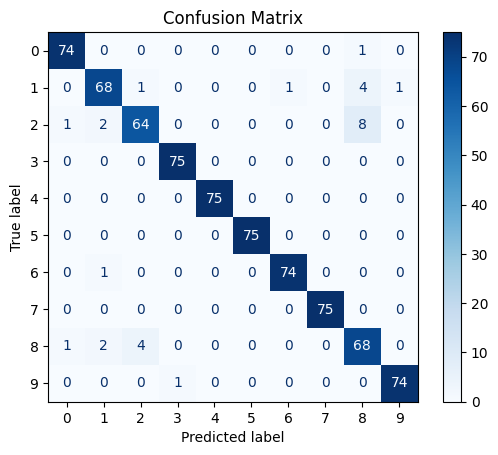

In [13]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
y_pred_list = []
y_test_list = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['data'], batch['label']
        
        # Get model predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class (highest probability)
        
        # Append predictions and true labels to the list
        y_pred_list.append(predicted.cpu().numpy())  # Move to CPU and convert to NumPy
        y_test_list.append(labels.cpu().numpy())  # Move to CPU and convert to NumPy

# Concatenate all batches
y_pred_np = np.concatenate(y_pred_list)
y_test_np = np.concatenate(y_test_list)

# Compute accuracy
accuracy = accuracy_score(y_test_np, y_pred_np)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print a detailed classification report (precision, recall, F1-score)
print("Classification Report:")
print(classification_report(y_test_np, y_pred_np))

# Generate confusion matrix
cm = confusion_matrix(y_test_np, y_pred_np)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [14]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Load your dataset
df = pd.read_csv("/kaggle/input/cwru-bearing-datasets/feature_time_48k_2048_load_1.csv")

# Define features and target
X = df.drop(columns=['fault'])  # Features
y = df['fault']  # Labels

# Split dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Use RandomizedSearchCV to randomly sample hyperparameters
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters: ", random_search.best_params_)
print("Best Cross-validation Accuracy: ", random_search.best_score_)

# Evaluate the model on the test set
y_pred = random_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 

In [15]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Load your dataset
df = pd.read_csv("/kaggle/input/cwru-bearing-datasets/feature_time_48k_2048_load_1.csv")

# Define features and target
X = df.drop(columns=['fault'])  # Features
y = df['fault']  # Labels

# Apply Label Encoding to convert string labels to numerical labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5]
}

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', random_state=42)

# Use RandomizedSearchCV to randomly sample hyperparameters
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                       n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the model to the training data
random_search_xgb.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters: ", random_search_xgb.best_params_)
print("Best Cross-validation Accuracy: ", random_search_xgb.best_score_)

# Predict on the test set
y_pred = random_search_xgb.best_estimator_.predict(X_test)

# Decode the predictions back to original labels
y_test_decoded = le.inverse_transform(y_test)
y_pred_decoded = le.inverse_transform(y_pred)

# Print the classification report
print(classification_report(y_test_decoded, y_pred_decoded))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.4